<h1>Procesamiento de datos a gran escala</h1>

# **Ejercicio de Tecnicas no Supervisadas**

## 5 de Noviembre de 2025

## Tomas Alejandro Silva Correal - Juan Guillermo Pabon Vargas

# Objetivo
<p><strong>Objetivo: </strong> El objetivo de este cuaderno es aplicar el algoritmo de clustering de partición a un conjunto de datos sencillos. Usando el concepto de aprendizaje no supervisado y el Algoritmo K-Means</p>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
  <li>Análisis y conclusiones</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [49]:
# Se importa wget 
import sys
#!{sys.executable} -m pip install wget

# Se importan tipos de Spark
from pyspark.sql.types import StructType, StructField, StringType, FloatType

# Se importa sesión Spark
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorAssembler, StandardScaler
# Se importa Pandas
import pandas as pd

In [3]:
# Leer datos desde archivo CSV por medio de wget
import wget

#Se crea la sesión
sparkA = SparkSession.builder.appName("IrisData").getOrCreate()

url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path ="Data_No_Supervisado/iris.data"
# wget.download(url_path,local_path)

# Se produce un schema inicial con los datos correspondientes
schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])

# En un dataframe, se lee el schema csv y se muestran sus primeros 5 resultados
df00 = sparkA.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 19:40:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [4]:
# Se imprime el schema realizado
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



In [5]:
# Se filtran nulos o imposibles
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+




### Aplicar Indexador a Columna "Species"

In [6]:
# Se instala indexador
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# Inicialización del StringIndexer 
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Se transforma el dataFrame con el indexador
indexed_df = indexerModel.transform(df00)
indexed_df.show(10)

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

In [7]:
# Se agrupan los elementos del dataFrame en sus distintas especies
indexed_df.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

<h3>Aplicar Algortimo K-Medias</h3>


Seleccione solo las columnas numéricas:

Se utiliza el algoritmo K means en clustering para agrupaciones iterativos y clusters esfericos, para este, se necesita o se toma en cuenta el numero de Clusters como parametro de entrada

In [8]:
# Se obtienen elementos del dataFrame df00 con especificaciones para un datafram con K-Means
df_kmeans = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df_kmeans.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

In [9]:
# Se usa el assembler para preparar los datos con las columnas de df_kmeans con output de nombre 'features'
assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol='features')
# Se transforma df00 con el assembler
df_datos = assembler.transform(df00)

# Los datos han sido formateados para KMeans en los vectores a usar



### Escalar los datos

In [10]:
# Se crea el escalador por medio de StandardScaler
escalador = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)

# Se ajusta el StandardScaler, para obtener estadisticas resumidas
modeloEscalado = escalador.fit(df_datos)

# Se normaliza cada elmento 'feature' para tener una unidad de desviacion
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[6.15892840615775...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[5.91740202781600...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[5.67587507362994...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[5.55511188445906...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[6.03816521698687...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



### Encontrar el número de clusters usando Silhouette Score

Este numero de clusters encontrado sera utilizado por k-means para las agrupaciones correspondientes, el algoritmo utilizado para encontrar el numero de clusters para K-Means se conoce como "Elbow method"

In [11]:
# Se importa K-Means de clustering y su respectivo evaluador
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

# Usando el evaluador, se evalua el modelo por medio de Clustering con los datos de entrada
evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10): # Se usa Kmeans para realizar el clustering usando los 'ScaledFeatures' y el indice en el for 
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    # Se ajusta el kmeans con el dataFrame df_datos
    KMeans_fit=kmeans.fit(df_datos)
    # Se transforma lo obtenido tras el ajuste 
    output = KMeans_fit.transform(df_datos)   
    # Se evalua la salida anterior por medio del ClusteringEvaluator
    score = evaluador.evaluate(output)   
    # Se agrega a la silueta el score evaluado
    silhouette_score.append(score)
    # Se muestra el numero de clusters por elemento y su score
    print('Silhouette Score for k =',i,'is',score)

25/11/05 19:40:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k = 2 is 0.7714149115179729
Silhouette Score for k = 3 is 0.643563342257829
Silhouette Score for k = 4 is 0.5753779807929382
Silhouette Score for k = 5 is 0.5245970103922054
Silhouette Score for k = 6 is 0.4999461476334194
Silhouette Score for k = 7 is 0.5354692452438727
Silhouette Score for k = 8 is 0.5434767415966535
Silhouette Score for k = 9 is 0.47613989601051354


### Visualización de silhouette scores

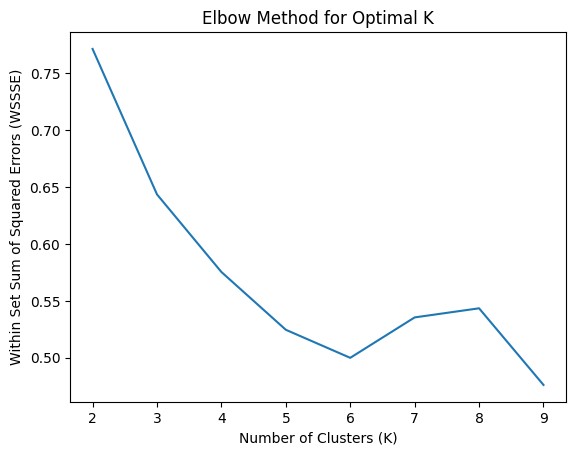

In [12]:
# Se importan herramientas de graficación
import matplotlib.pyplot as plt

# Se genera una grafica inicial con los datos de la silueta siendo la relacion de WSSSE y la cantidad de clusters para un K optimo
plt.plot(range(2,10),silhouette_score)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.show()

## **Análisis**
En la gráfica anterior, se presenta la relación entre el numero de clusters y el WSSSE, en este, se busca el K en donde la disminución se relentize al punto de generar una curva, y donde la decaida no sea graudal, formando un "codo" (segun lo consideradi por el "Elbow Method"). Este cambio ocurre alrededor de K(3), siendo este entonces el seleccionado para su posterior trabajo. Fuera de lo ya dicho, el conjunto de datos presenta solamente 3 especies, loq eu tambien afecta al K a elegir, sin contar que durante la separación se pueden hallar subespecies

Respecto a la calidad de los resultados, se puede evidenciar como el WSSSE es bajo en su disminución, dando un resultado satisfactorio en el sentido de cohesión, sin embargo, en el caso de K(2) los clusters son demasiado dispersos, implicando que su WSSSE es demasiado alto y poco optimo para su uso. K(8) presenta el valor mas bajo, implicando una mejor cohesión, y K(9) aumenta nuevamente, un comportamiento inusual que puede implicar errores.

Dado esto, se utiliza K(3) para trabajar a posteriori.

Comparando K(4), K(6) y K(8), se puede notar como: K(4) cuenta con un buen balance, el cual disminuye aun mas llegando a K(6) hasta llegar a K(8), que como se mencionó anteriormente, es el presentado como numero de clusters con mejor cohesión.

### Entrenar el modelo
Se entrenara un modelo de predicción con los datos obtenidos usando el numero de clusters seleccionado con anterioridad segun  los resultados de valores de silueta

In [36]:
# Se realiza K-Means con un total de 3 clusters elegidos como resultado de previos análisis, con valores de "scaledFeatures" y cluster como columna de predicción
kmeans = KMeans(k=3, featuresCol="scaledFeatures", predictionCol="cluster")
# Se ajusta el modelo con kmeans usando el dataFrame de datos
kmeans_model = kmeans.fit(df_datos)

output = kmeans_model.transform(df_datos)

### Evaluar el modelo k=3 Within Set Sum of Squared Errors (WSSSE) metric

In [14]:
# Se ajustan elementos del dataFrame por medio de KMeans al centroide
output = KMeans_fit.transform(df_datos)
# Se evalua el WSSSE en el nuevo Output dado el numero de clusters
wssse = evaluador.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.47613989601051354


### Visualizar los Datos

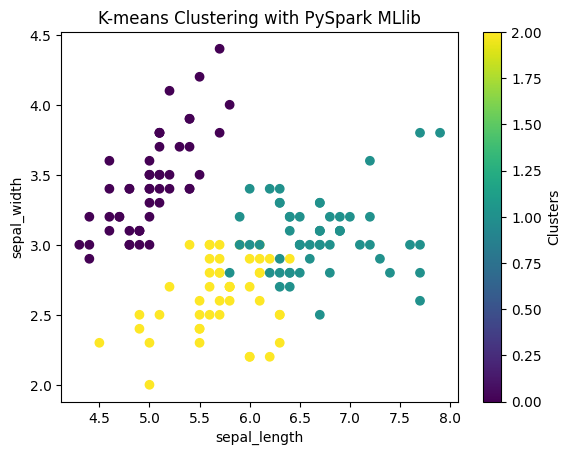

In [38]:
# Se covierten los datos agrupados a un modelo Pandas
clustered_data_pd = output.toPandas()

# Se muestran los resultados
plt.scatter(
    clustered_data_pd["sepal_length"],
    clustered_data_pd["sepal_width"],
    c=clustered_data_pd["cluster"], 
    cmap='viridis'
)
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Clusters")
plt.show()

## **Análisis**
Se puede evidenciar como se han generado clusters o agrupaciones segun valores de sepal, tanto largo como ancho, estos grupos deberan de ajustarse a los K=3 clusters realizados segun su centoride.

El rango de clusters va de 0 a 2.0 para cada valor, implicando 3 clusters generados inicialmente, el cluster con mejor definición se encuentra en la parte superior-izquierda del diagrama, los demas sin embargo, se encuentran mas esparcidos, superpuestos.

La separación se realizo correctamente segun los 3 clusters que debian de formarse, indicnado u correcto funcionamiento, aunque con un amplio nivel de esparcimiento.

In [16]:
# Se muestran las columnas de los datos
df_datos.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures']

In [17]:
output.columns

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'Species',
 'features',
 'scaledFeatures',
 'prediction']

Text(0.5, 1.0, 'Conjunto Iris')

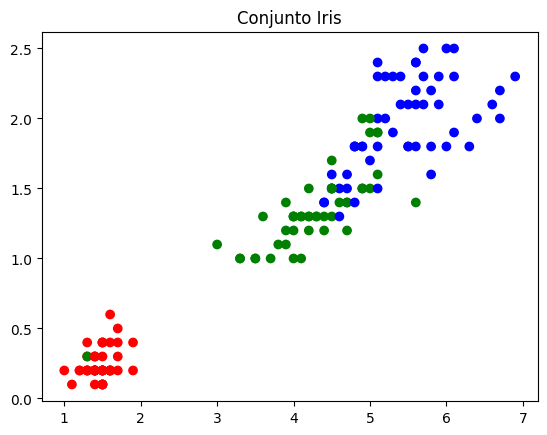

In [39]:
#Visualizando con Matplotlib
# Se importa numpy
import numpy as np
# Se importa la libreria de matplotlib
import matplotlib.pyplot as plt
# Se obtiene un arreglo de colores por cluster
color =np.array(['red','blue','green','cyan','yellow','purple','brown','grey','pink'])
df_pd = output.toPandas()

# Se genera un esparcimiento con los detalles de las flores y petales, con datos como los colores y un titulo
scatter = plt.scatter(x=df_pd["petal_length"],y=df_pd["petal_width"],c=color[df_pd["cluster"]])
plt.title("Conjunto Iris")


## **Análisis**

Tras realizar el segundo esparcimiento y graficación, se puede notar como los datos ahora estan mucho mas agrupados, contando aun con 3 clusters de partición, estos se agrupan en tres puntos principalmente, tal como deberia de suceder, indicando una mayor cercania al centroide y una mayor compactación de los datos. Se muestra un grupo bien definido (inferior izquierda), mientras que los otros dos tienen un mayor esparcimiento, siendo esto un comportamiento comun en el algoritmo K-Means.

In [19]:
# Se convierte al Output en objeto GeoPandas
df_pd = output.toPandas()

In [28]:
# Se muestran datos unicos de predicción
df_pd["prediction"].unique()

array([0, 5, 8, 4, 2, 6, 7, 3, 1], dtype=int32)

Text(0.5, 1.0, 'Conjunto Iris Sepal')

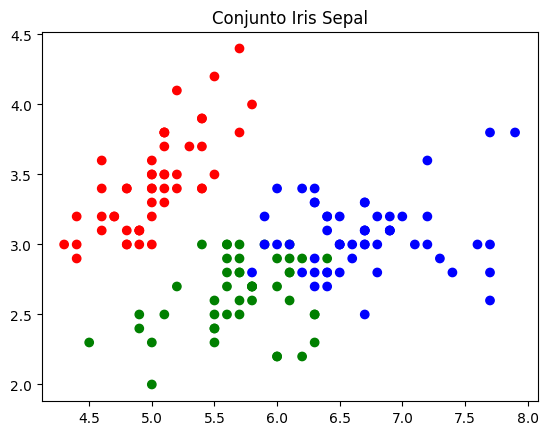

In [40]:
#Visualizando con Matplotlib
import matplotlib.pyplot as plt
color =np.array(['red','blue','green','cyan','yellow','purple','brown','grey','pink'])
scatter = plt.scatter(x=df_pd["sepal_length"],y=df_pd["sepal_width"],c=color[df_pd["cluster"]])
plt.title("Conjunto Iris Sepal")

## **Análisis**
A diferencia de la grafica anterior, en esta no se comparan los petalos, sino que en su lugar, son los Sépalos los revisados, y a diferencia del caso anterior, estos datos parecen ser mucho mas dispersos y poco agrupados. Se logra a evidenciar vagamente dos agrupaciones (principalmente la agrupación en la zona superior-izquierda), aun con los 3 clusters de partición, los datos cuentan con demasiada diferenciación como para agruparse segun los procesos de K-Means, hay datos superpuestos, en conjunto indicando una menor separación entre especies, y a pesar de que los conjuntos se separen en los 3 cluster de forma debida, no se presenciaban de una forma tan agrupada como era el caso para los petalos.

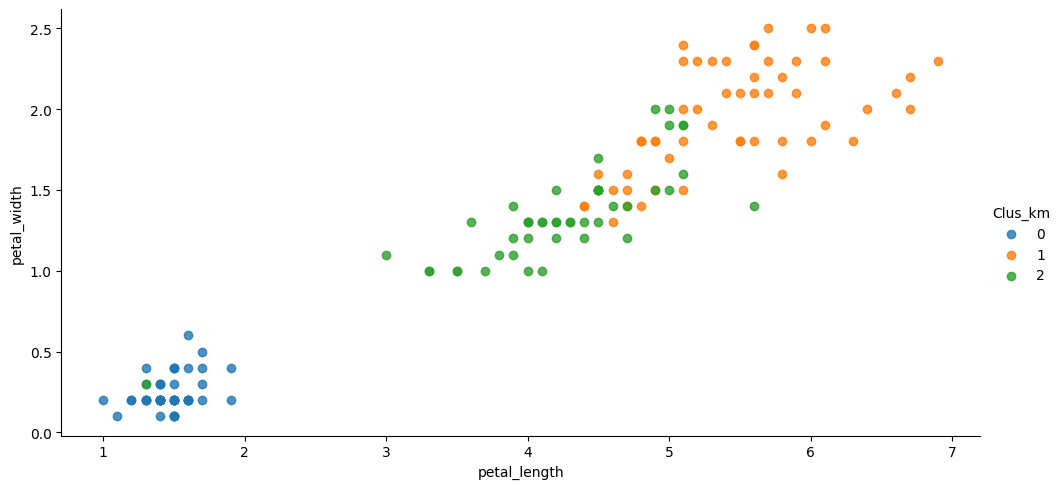

In [57]:
#Visualizando con Seaborn
import seaborn as sns
df_pd["Clus_km"] = df_pd["cluster"]
labels = pd.DataFrame(df_pd["cluster"], columns=['Clus_km'])

labels = df_pd["cluster"]
sns.lmplot(x='petal_length',y='petal_width',data=df_pd,hue='Clus_km',fit_reg=False, height = 5, aspect = 2)

## **Análisis**

Para esta grafica se opta por usar Seaborn, como alternativa para graficar los datos, en esta los resultados son similares, sino identicos al caso original con matPlotLib, con los mismos clusters y esparcimientos, aunque aqui, se muestra a mas detalle a nivel numerico los valores y sus respectivos cluster.

In [58]:
# Finalmente, se frena el servicio de Spark
sparkA.stop()

# Conclusiones y Observaciones

El cuaderno trabajado durante este periodo muestra un ejempo de análisis de datos por medio de tecnicas no supervisadas, en especifico: Clustering por medio de K-Means. En este se analizaron datos respecto a caracateristicas de especies de planta, las cuales se categorizan y se agrupan por medio de clustering. Se optó por realizar 3 clusters, dado al elbow test y al numero total de especies de la fuente. Los resultados indican en un punto general un correcto funcionamiento del algoritmo K-Means para la agrupación o clustering por partición de datos con caracteristicas similares.